In [2]:
from __future__ import print_function
from pythtb import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def chessboard(t0, tprime, delta):
    # define lattice vectors
    lat=[[1.0, 0.0], [0.0, 1.0]]
    # define coordinates of orbitals
    orb=[[0.0, 0.0], [0.5, 0.5]]

    # make two dimensional tight-binding checkerboard model
    model = tb_model(2, 2, lat, orb)

    # set on-site energies
    model.set_onsite([-delta, delta], mode='reset')

    # set hoppings (one for each connected pair of orbitals)
    # (amplitude, i, j, [lattice vector to cell containing j])
    model.set_hop(-t0, 0, 0, [1, 0], mode='reset')
    model.set_hop(-t0, 0, 0, [0, 1], mode='reset')
    model.set_hop(t0, 1, 1, [1, 0], mode='reset')
    model.set_hop(t0, 1, 1, [0, 1], mode='reset')

    model.set_hop(tprime, 1, 0, [1, 1], mode='reset')
    model.set_hop(tprime*1j, 1, 0, [0, 1], mode='reset')
    model.set_hop(-tprime, 1, 0, [0, 0], mode='reset')
    model.set_hop(-tprime*1j, 1, 0, [1, 0], mode='reset')

    return model

In [ ]:
# parameter arrays
num_param = 15
t0_arr = np.linspace(0, 0.5, num_param)
t_prime_arr = np.linspace(0, 0.5, num_param)
delta = 1

for i in range(num_param):
    for j in range(num_param):
        # set parameters
        t0, tprime = t0_arr[i], t_prime_arr[j]

        # make wf_array for entire BZ
        model = chessboard(t0, tprime, delta)
        my_array_whole = wf_array(model, [50, 50])
        my_array_whole.solve_on_grid([0,0])

        # compute chern number
        n_occ = int(model.get_num_orbitals()/2)
        chern = my_array_whole.berry_flux([i for i in range(n_occ)])/ (2*np.pi)
        print(f'indices: {i, j}, Chern number = {chern: .1f} | Delta = {delta: .1f}, t0 = {t0: .5f} tprime = {tprime: .4f}')

Chern number is non-zero for $t_0 > \Delta/4$

## Band structure plots

In [4]:
# trivial parameters (C = 0)
delta = 1
t0 = .1
tprime = .1

model = chessboard(t0, tprime, delta)

In [5]:
# print tight-binding model
# model.display()
# model.visualize(0, 1)

In [6]:
# generate k-point path and labels
nk = 51
path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
(k_vec, k_dist, k_node) = model.k_path(path, nk, report=False)

evals = model.solve_all(k_vec)

Text(0, 0.5, 'Band energy')

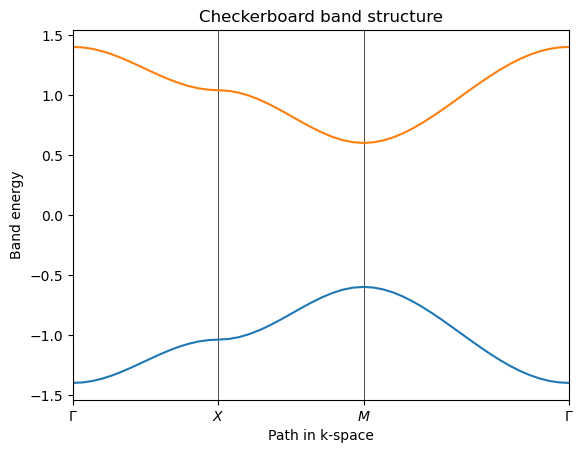

In [7]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(2):
  ax.plot(k_dist, evals[n])

ax.set_title("Checkerboard band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

### Doubling the unit cell (band folding)

In [8]:
# double unit cell in both directions (reduced units)
model = chessboard(t0, tprime, delta).make_supercell([[2,0],[0,2]])

# adding disorder
J = 3
J_site = 2
model.set_onsite(J, ind_i = J_site, mode='add')

In [9]:
# model.display()

In [10]:
# dbld_cell.visualize(0, 1)

In [11]:
(k_vec_dbld, k_dist_dbld, k_node_dbld) = model.k_path(path, nk, report=False)

evals_dbld = model.solve_all(k_vec)

Text(0, 0.5, 'Band energy')

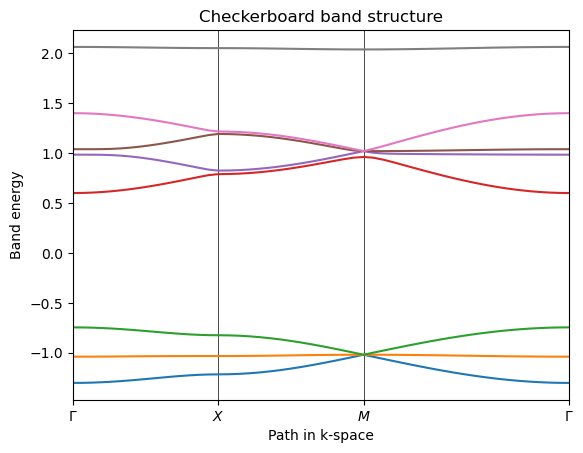

In [12]:
fig, ax = plt.subplots()

ax.set_xlim(0, k_node_dbld[-1])
ax.set_xticks(k_node_dbld)
label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
ax.set_xticklabels(label)
for n in range(len(k_node_dbld)):
  ax.axvline(x=k_node_dbld[n], linewidth=0.5, color='k')

for n in range(len(evals_dbld)):
  ax.plot(k_dist_dbld, evals_dbld[n])

ax.set_title("Checkerboard band structure")
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy")

## Finding singularities in $det(S_k)^{-1/2}$

### Primitive unit cell

In [13]:
# parameter arrays
num_param = 8
t0_arr = np.linspace(0, 1, num_param)
t_prime_arr = np.linspace(0, 1, num_param)

In [14]:
det_Sk = np.zeros((num_param, num_param, nk))
chern_arr = np.zeros((num_param, num_param))


for i in range(num_param):
    for j in range(num_param):
        # set parameters
        t0, tprime = t0_arr[i], t_prime_arr[j]

        # make wf_array for entire BZ
        model = chessboard(t0, tprime, delta)
        my_array_whole = wf_array(model, [nk, nk])
        my_array_whole.solve_on_grid([0,0])

        # compute chern number
        n_occ = int(model.get_num_orbitals()/2)
        chern = my_array_whole.berry_flux([i for i in range(n_occ)])/ (2*np.pi)
        chern_arr[i, j] = chern
        print(f'indices: {i, j}, Chern number = {chern: .2f} | Delta = {delta: .2f}, t0 = {t0: .2f} tprime = {tprime: .2f}')

        # find det(S_k) on path in k-space
        my_array_path = wf_array(model, [nk])
        for k in range(k_vec.shape[0]):
            my_array_path.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])
            det_Sk[i, j, k] = np.abs(my_array_path[k][0][0]) # overlap of lower energy state with delta function on site at origin of unit cell

/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


indices: (0, 0), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.00
indices: (0, 1), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.14
indices: (0, 2), Chern number = -0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.29
indices: (0, 3), Chern number = -0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.43
indices: (0, 4), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.57
indices: (0, 5), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.71
indices: (0, 6), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  0.86
indices: (0, 7), Chern number =  0.00 | Delta =  1.00, t0 =  0.00 tprime =  1.00
indices: (1, 0), Chern number =  0.00 | Delta =  1.00, t0 =  0.14 tprime =  0.00
indices: (1, 1), Chern number =  0.00 | Delta =  1.00, t0 =  0.14 tprime =  0.14
indices: (1, 2), Chern number = -0.00 | Delta =  1.00, t0 =  0.14 tprime =  0.29
indices: (1, 3), Chern number =  0.00 | Delta =  1.00, t0 =  0.14 tprime =  0.43
indices: (1, 4), Chern numbe

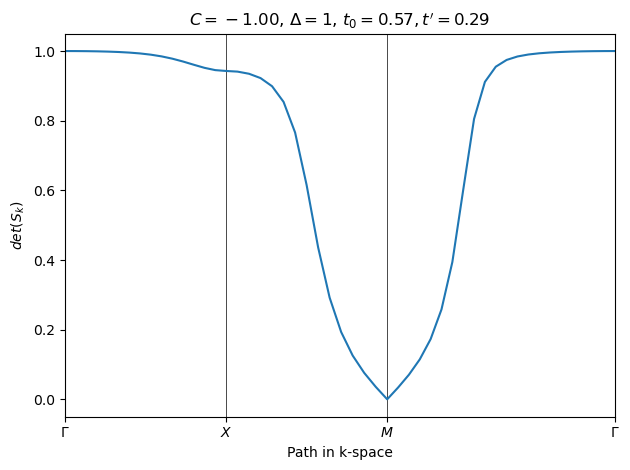

In [15]:
# parameter indicies
idx1, idx2 = 4, 2

fig, ax = plt.subplots()
ax.set_xlim(0,k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

ax.plot(k_dist, det_Sk[idx1, idx2, :])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .2f}$, $\Delta = {delta}$, $t_0= {t0_arr[idx1]: .2f}, t' = {t_prime_arr[idx2]: .2f}$")
ax.set_xlabel("Path in k-space")
ax.set_ylabel(r"$det(S_k)$")
fig.tight_layout()

##  Doubled unit cell 

- Add disorder on 1 site to break symmetry and remove degeneracies
- Use SVD of $A_k$ to see where the singular values go to zero. At these points, there is a divergence in Wannier construction

In [17]:
delta = 1
t0 = t0_arr[idx1]
tprime = t_prime_arr[idx2]

model = chessboard(t0, tprime, delta).make_supercell([[2,0],[0,2]])

# # adding disorder
# J = 2
# J_site = 2
# model.set_onsite(5, ind_i = J_site, mode='add')
# model.set_onsite(2, ind_i = 4, mode='add')

# wave function storage
wfs = wf_array(model, [nk])

In [18]:
# model.display()

-  lower energy sites are 0, 2, 4, 6
-  trial function is delta function at each of these sites
- $A(k)$ is a matrix that is the overlap of each eigenstate with a given trial function

In [19]:
trial_orbitals = [0, 2, 4, 6]
num_occ_bands = 4

A = np.zeros((nk, num_occ_bands, len(trial_orbitals)), dtype=complex)
V = np.zeros((nk, num_occ_bands, num_occ_bands), dtype=complex)
S = np.zeros((nk, len(trial_orbitals)), dtype=complex)
W = np.zeros((nk, len(trial_orbitals), len(trial_orbitals)), dtype=complex)

for k in range(nk):
    wfs.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])
    # constructing A
    A[k, :, :] = [[wfs[k][i][j].conj() for j in trial_orbitals] for i in range(num_occ_bands)]
    # SVD
    V[k, :, :], S[k, :], W[k, :, :] = np.linalg.svd(A[k])

/Users/treycole/mambaforge/envs/rutgers/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


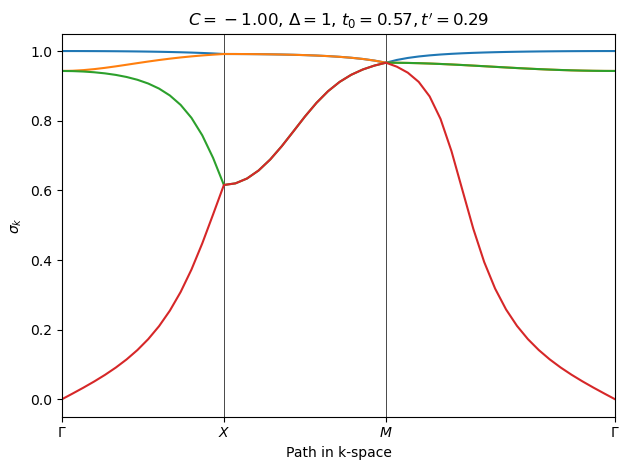

In [20]:
fig, ax = plt.subplots()

ax.set_xlim(0,k_node[-1])
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(S.shape[1]):
  ax.plot(k_dist, S[:, n])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .2f}$, $\Delta = {delta}$, $t_0= {t0_arr[idx1]: .2f}, t' = {t_prime_arr[idx2]: .2f}$")
ax.set_xlabel("Path in k-space")
ax.set_ylabel(r"$\sigma_k$")
fig.tight_layout()

- trying fewer trial functions
- zeros dissappear independent of set of trial functions
- not very localized 
- fewer trial functions -> more localized

In [21]:
trial_orbitals = [0, 2, 4]
num_occ_bands = 4

A = np.zeros((nk, num_occ_bands, len(trial_orbitals)), dtype=complex)
V = np.zeros((nk, num_occ_bands, num_occ_bands), dtype=complex)
S = np.zeros((nk, len(trial_orbitals)), dtype=complex)
W = np.zeros((nk, len(trial_orbitals), len(trial_orbitals)), dtype=complex)

for k in range(nk):
    wfs.solve_on_one_point([k_vec[k,0], k_vec[k,1]], [k])
    # constructing A
    A[k, :, :] = [[wfs[k][i][j].conj() for j in trial_orbitals] for i in range(num_occ_bands)]
    # SVD
    V[k, :, :], S[k, :], W[k, :, :] = np.linalg.svd(A[k])

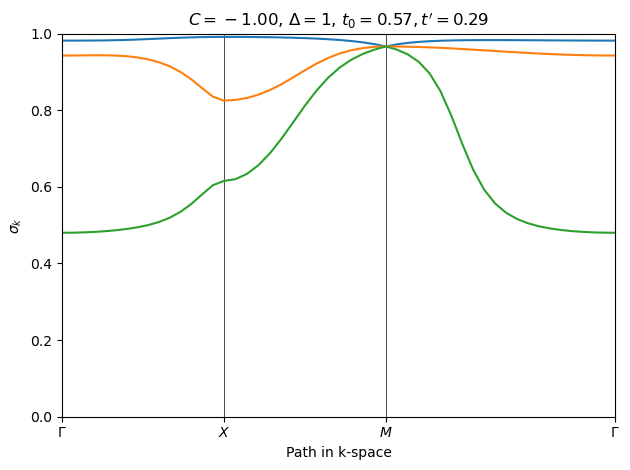

In [22]:
fig, ax = plt.subplots()

ax.set_xlim(0,k_node[-1])
ax.set_ylim(0,1)
ax.set_xticks(k_node)
ax.set_xticklabels(label)
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')

for n in range(S.shape[1]):
  ax.plot(k_dist, S[:, n])

ax.set_title(fr"$C = {chern_arr[idx1, idx2]: .2f}$, $\Delta = {delta}$, $t_0= {t0_arr[idx1]: .2f}, t' = {t_prime_arr[idx2]: .2f}$")
ax.set_xlabel("Path in k-space")
ax.set_ylabel(r"$\sigma_k$")
fig.tight_layout()